# Animal pose dataset preparation for ControlNet training with OpenPifPaf and Hugging Face

_By: MediaPipe team (Google), Diffusers team (Hugging Face), John Fozard (jfozard)_

This notebook provides an end-to-end example of preparing a dataset that is compatible with [ControlNet training](https://github.com/huggingface/diffusers/tree/main/examples/controlnet) using OpenPifPaf and Hugging Face. Specifically, in this notebook, we

* Load the [Stanford Dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs) using TensorFlow Datasets.
* Prepare conditioning images from the original images of the dataset using [OpenPifPaf](https://github.com/openpifpaf/openpifpaf) which has an [animal pose model](https://openpifpaf.github.io/plugins_animalpose.html)
* Generate captions of the original images using BLIP-2 using [🤗 Transformers](https://huggingface.co/docs/transformers).
* Prepare the final dataset using [🤗 Datasets](https://huggingface.co/docs/datasets) and push it to the Hugging Face Hub. 

Let's get started!

## Install libraries

In [30]:
!pip install -q datasets transformers accelerate openpifpaf matplotlib opencv-python-headless tqdm

## Load the dataset

Load the `train` set of the dataset. 

In [1]:
import torch


/home/foz/miniconda3/envs/hf_dataset/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!pip install tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 7.9 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.53.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.0 MB)
  Using cached h5py-3.8.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached jax-0.4.8.tar.gz (1.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached libclang-16.0.0-py2.py3-none-manyli

  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439678 sha256=db7ce84f7d259f0151b2a496cb84b69c67f97ad8c9cce6bdc5449e7b4abdb1ef
  Stored in directory: /home/foz/.cache/pip/wheels/05/94/dc/81042da9bced43ff430bc02043d213d9e4b210b584c39e31c1
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21484 sha256=8b7c14a19edb66aceb4f928bf3cc8e46a9e8b197b52caf23895e33443464ea04
  Stored in directory: /home/foz/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built jax promise
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
## Need to stop tf allocating all of the GPU memory - probably shouldn't mix pt and tf like this.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

dataset = tfds.load("stanford_dogs", split="train")

2023-04-16 14:19:52.635121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 14:19:52.636095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 14:19:52.636249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Very basic preprocessing pipeline - I think the dataset does have a bounding box for the dog we could use.

In [5]:
IMG_SIZE = 512

def crop_center(image):
    print(image.shape)
    h, w = image.shape[-3], image.shape[-2]
    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
    return tf.image.resize_images(cropped_image, (IMG_SIZE, IMG_SIZE))

def preprocess_image(example):
    # extract the image and label from the example
    image = example['image']
    label = example['label']
    
    shape = tf.shape(image)
    height = shape[0]
    width = shape[1]
    
    crop_size = tf.minimum(height, width)
    crop_offset_height = (height - crop_size) // 2
    crop_offset_width = (width - crop_size) // 2
    image = tf.image.crop_to_bounding_box(image, crop_offset_height, crop_offset_width, crop_size, crop_size)

    # resize the image to the desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    

    # normalize the image
    image = tf.cast(image, tf.uint8)

    return {'image': image, 'label': label}

Let's visualize a few samples.

In [6]:
dataset = dataset.map(preprocess_image)


2023-04-16 14:20:02.809819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]
2023-04-16 14:20:02.810105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]


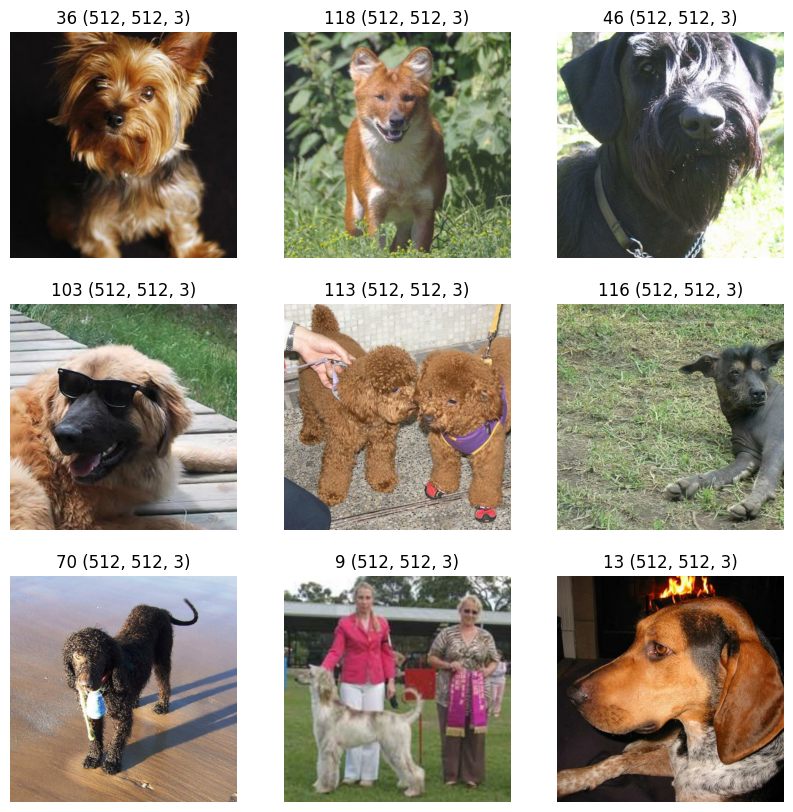

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for i, sample in enumerate(dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample["image"])
    plt.title(f'{sample["label"]} {sample["image"].shape}')
    plt.axis("off")

Here everything is a picture of a dog, and all dogs are good dogs, so no need to filter the dataset. If some non-dogs had snuck into the dataset these would need to be filtered out. (Note that there are some images that look suspiciously like foxes).

**NB OpenPifPaf has some profiling code included that increases its memory usage** - these are in the decoder.py file.
We may need to patch this properly.

In [8]:
import openpifpaf
openpifpaf.show.Canvas.show = True
openpifpaf.show.Canvas.image_min_dpi = 100

In [9]:
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30-animalpose')
predictor.long_edge = 512
predictor.preprocess = predictor._preprocess_factory()

In [10]:
meta = openpifpaf.plugins.animalpose.animal_kp.AnimalKp().head_metas[0]

We can use the built-in annotation code to plot the reference skeleton

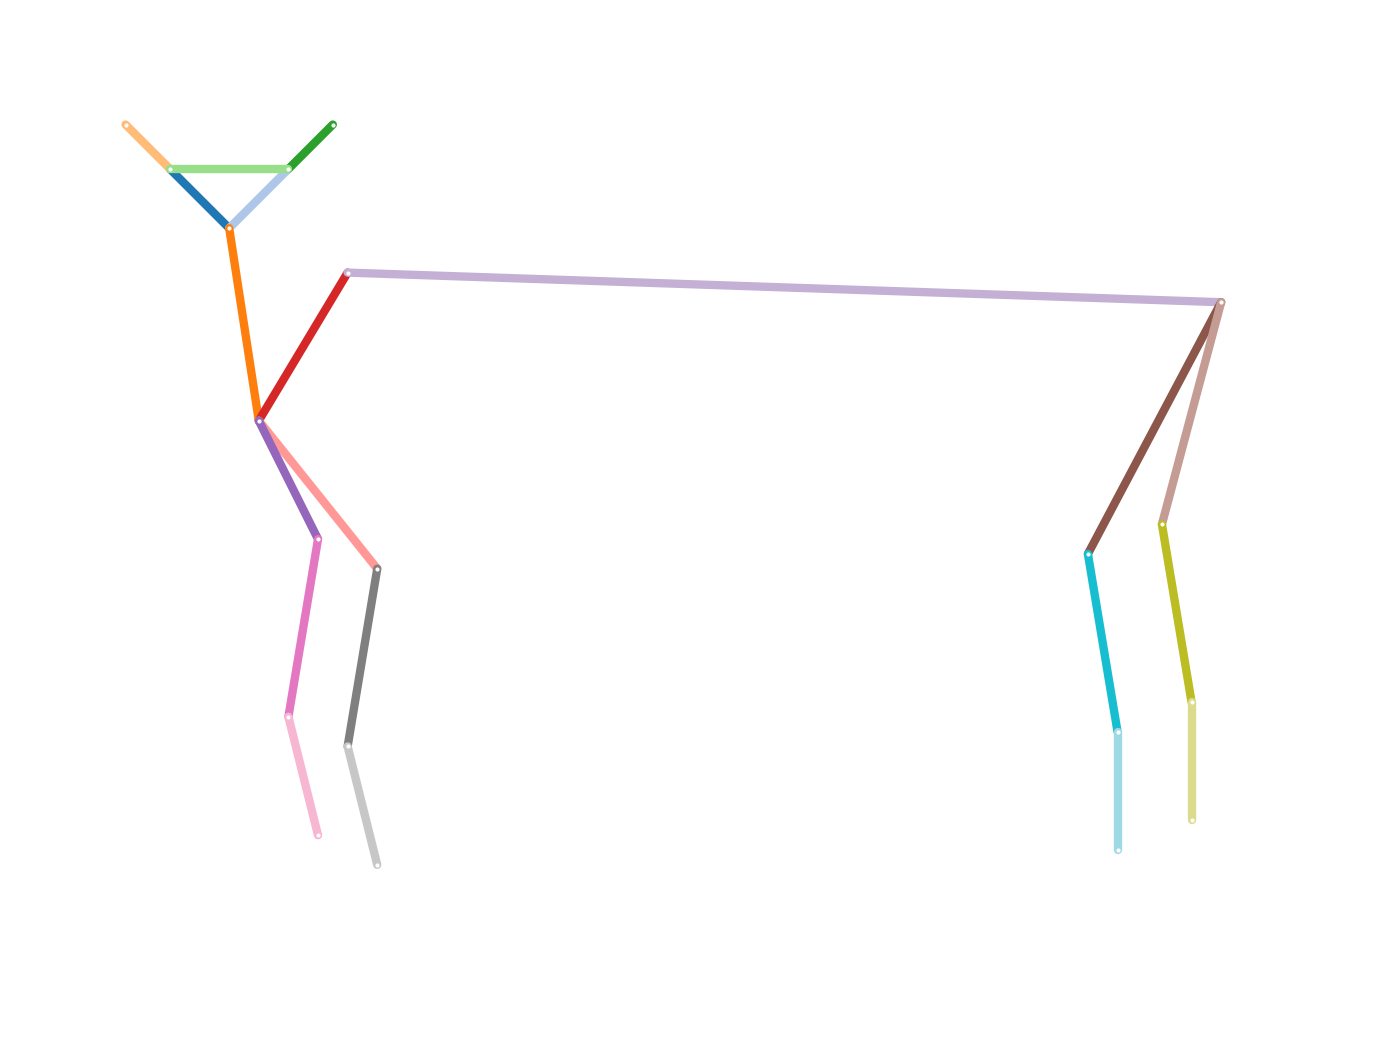

In [11]:
# HIDE CODE
# first make an annotation
ann_animal = openpifpaf.Annotation.from_cif_meta(meta)

# visualize the annotation
openpifpaf.show.KeypointPainter.show_joint_scales = False
openpifpaf.show.KeypointPainter.line_width = 3
keypoint_painter = openpifpaf.show.KeypointPainter()
with openpifpaf.show.Canvas.annotation(ann_animal) as ax:
    keypoint_painter.annotation(ax, ann_animal)

There are different keypoints for dogs compared to humans - we list these here

In [12]:
meta

Cif(name='cif', dataset='animal', head_index=None, base_stride=None, upsample_stride=1, keypoints=['Nose', 'L_eye', 'R_eye', 'L_ear', 'R_ear', 'Throat', 'Tail', 'withers', 'L_F_elbow', 'R_F_elbow', 'L_B_elbow', 'R_B_elbow', 'L_F_knee', 'R_F_knee', 'L_B_knee', 'R_B_knee', 'L_F_paw', 'R_F_paw', 'L_B_paw', 'R_B_paw'], sigmas=[0.026, 0.025, 0.025, 0.035, 0.035, 0.079, 0.079, 0.079, 0.072, 0.072, 0.072, 0.072, 0.087, 0.087, 0.087, 0.087, 0.089, 0.089, 0.089, 0.089], pose=array([[ 0. ,  4.3,  2. ],
       [-0.4,  4.7,  2. ],
       [ 0.4,  4.7,  2. ],
       [-0.7,  5. ,  2. ],
       [ 0.7,  5. ,  2. ],
       [ 0.2,  3. ,  2. ],
       [ 6.7,  3.8,  2. ],
       [ 0.8,  4. ,  2. ],
       [ 1. ,  2. ,  2. ],
       [ 0.6,  2.2,  2. ],
       [ 5.8,  2.1,  2. ],
       [ 6.3,  2.3,  2. ],
       [ 0.8,  0.8,  2. ],
       [ 0.4,  1. ,  2. ],
       [ 6. ,  0.9,  2. ],
       [ 6.5,  1.1,  2. ],
       [ 1. ,  0. ,  2. ],
       [ 0.6,  0.2,  2. ],
       [ 6. ,  0.1,  2. ],
       [ 6.5,  0

We can use the example code from the openpose website to detect the pose keypoints on our image

2023-04-16 14:20:15.319357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [4]
	 [[{{node Placeholder/_3}}]]
2023-04-16 14:20:15.319868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]


(512, 512, 3)
src/openpifpaf/csrc/src/cif_hr.cpp:102: UserInfo: resizing cifhr buffer
src/openpifpaf/csrc/src/occupancy.cpp:53: UserInfo: resizing occupancy buffer


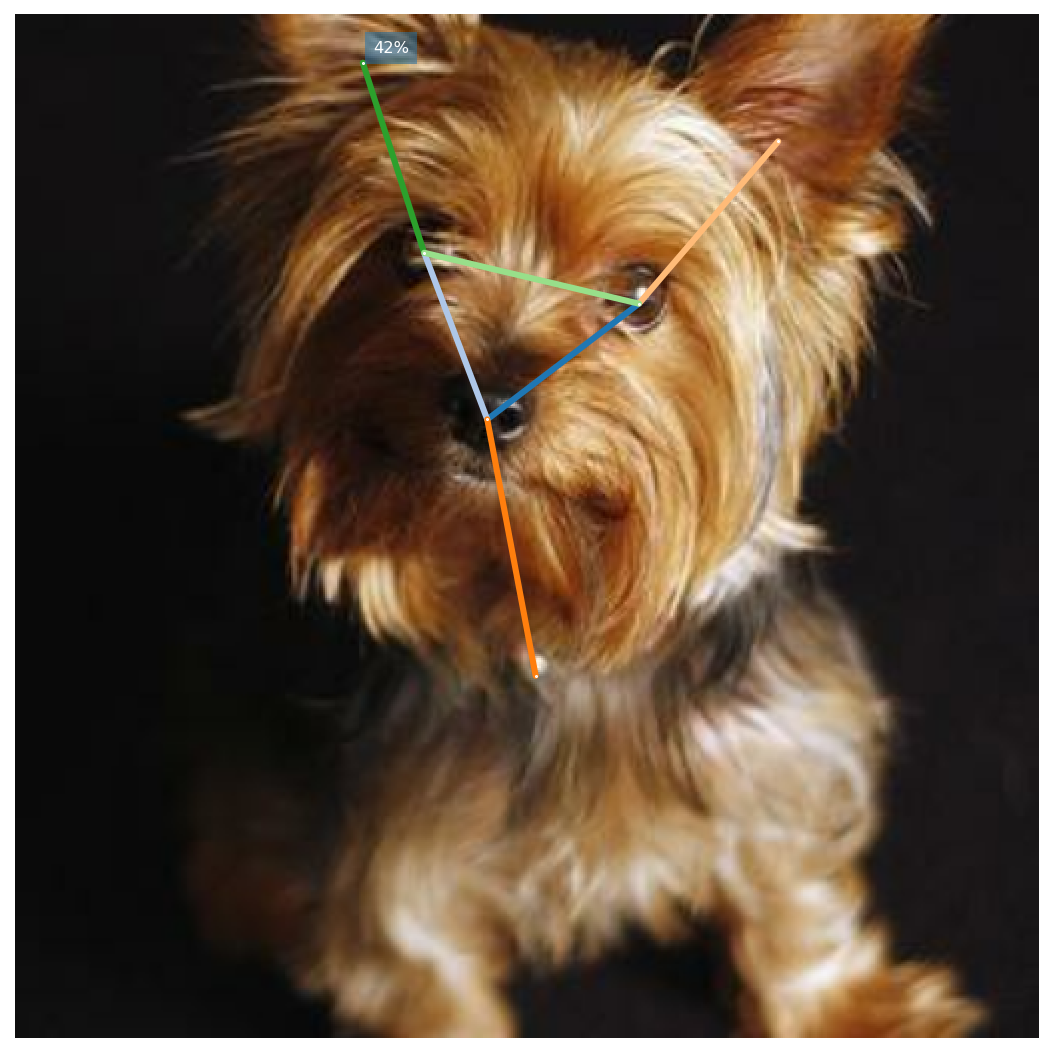

In [13]:
sample = next(iter(dataset))
im = np.asarray(sample['image'])
print(im.shape)
predictions, gt_anns, image_meta = predictor.numpy_image(im)
annotation_painter = openpifpaf.show.AnnotationPainter()
with openpifpaf.show.image_canvas(im) as ax:
    annotation_painter.annotations(ax, predictions)

The OpenPifaf predictions are part of this prediction structure. I think the columns of
the array are x and y position, and the score of that keypoint.
The standard plotting functions in Openpifaf draw all keypoints > 0.0,
and draw solid lines if the keypoints at either ends have scores > 0.5.

In [14]:
predictions[0].data

array([[235.81732   , 202.02559   ,   0.8297756 ],
       [311.65616   , 144.13148   ,   0.80377096],
       [204.27519   , 118.70081   ,   0.73536766],
       [381.29202   ,  63.00956   ,   0.52309316],
       [173.58186   ,  23.65012   ,   0.7145884 ],
       [260.0176    , 330.2098    ,   0.56268704],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

In [15]:
## Openpifaf uses the following colour scheme
# color = matplotlib.cm.get_cmap('tab20')((color % 20 + 0.05) / 20)

In [16]:
openpifaf_colors = [matplotlib.cm.get_cmap('tab20')((i % 20 + 0.05) / 20) for i in range(20)]
openpifaf_colors

/tmp/ipykernel_115220/2253772054.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  openpifaf_colors = [matplotlib.cm.get_cmap('tab20')((i % 20 + 0.05) / 20) for i in range(20)]


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7803921568627451

It's probably better for ControlNet to use fully saturated colours - we want them to be as different as possible

The connections listed in the OpenPifaf metadata are for a 1-based array
 but in python we prefer zero-based, so subtract 1 from them

In [17]:
zero_based_skeleton = [ (a-1, b-1) for a,b in meta.draw_skeleton]

In [18]:
# Adapted MediaPipe Pose annotation for ControlNet.
# There are fewer keypoints (20) and different connections
# for animals compared to humans

from typing import Any
import numpy as np
import math
import cv2

# Body joint color map. #BGR
_JOINT_CMAP = {
    0: [0, 0, 255],
    1: [255, 208, 0],
    2: [255, 161, 0],
    3: [255, 114, 0],
    4: [0, 189, 255],
    5: [0, 236, 255],
    6: [0, 255, 226],
    7: [255, 0, 76],
    8: [0, 255, 131],
    9: [255, 0, 171],
    10: [0, 255, 37],
    11: [244, 0, 253],
    12: [57, 255, 0],
    13: [151, 0, 255],
    14: [151, 255, 0],
    15: [57, 0, 255],
    16: [245, 255, 0],
    17: [0, 39, 255],
    18: [255, 169, 0],
    19: [0, 133, 255],
}


# Connection color map. #BGR
# These colors probably matter a little, and it's not clear
# exactly how to choose them
# For instance - should they be similar to the keypoint colours or not?
# I've just taken them from the example notebook

_CONNECTION_CMAP = {
 (0, 1): [127, 104, 127],
 (0, 2): [0, 94, 255],
 (0, 5): [255, 184, 0],
 (1, 3): [255, 137, 0],
 (2, 4): [255, 57, 38],
 (1, 2): [0, 212, 255],
 (5, 7): [0, 245, 240],
 (5, 8): [0, 255, 178],
 (5, 9): [127, 127, 104],
 (6, 7): [150, 127, 126],
 (6, 10): [197, 0, 254],
 (6, 11): [122, 127, 221],
 (9, 13): [104, 255, 0],
 (13, 17): [156, 127, 56],
 (8, 12): [104, 0, 255],
 (12, 16): [198, 255, 0],
 (11, 15): [28, 19, 255],
 (15, 19): [28, 66, 255],
 (10, 14): [28, 114, 255],
 (14, 18): [250, 212, 0],
}

# The connections liste


In [19]:
def draw_pose(
    image: np.ndarray,
    landmark_list: Any,
    connections: Any,
    overlay: bool = True,
) -> tuple[np.ndarray, dict[str, list[float]]]:
    """Draws the landmarks and the connections on the image.

    Args:
      image: A three channel BGR image represented as numpy ndarray.
      landmark_list: A normalized landmark list proto message to be annotated on
        the image.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected in the drawing.
      overlay: Whether to overlay on the input image.

    Returns:
      (image, dictionary).

    Raises:
      ValueError: If one of the following:
        a) If the input image is not three channel BGR.
        b) If any connetions contain invalid landmark index.
    """
    if image.shape[2] != 3:
        raise ValueError("Input image must contain three channel bgr data.")
    image_rows, image_cols, _ = image.shape
    min_length = min(image_rows, image_cols)
    draw_line_width = math.floor(min_length * 0.01)
    draw_circle_radius = math.floor(min_length * 0.015)
    idx_to_coordinates = {}
    
    for idx, landmark in enumerate(landmark_list):
        if landmark[2]>0.0:
            idx_to_coordinates[idx] = (int(landmark[0]), int(landmark[1]))
            
    if overlay:
        output_image = image.copy()
    else:
        output_image = np.zeros(
            list(image.shape[:2])
            + [
                3,
            ],
            dtype=np.uint8,
        )

    if connections:
        num_landmarks = len(landmark_list)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    "Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                cv2.line(
                    output_image,
                    pt1=idx_to_coordinates[start_idx],
                    pt2=idx_to_coordinates[end_idx],
                    color=_CONNECTION_CMAP[(start_idx, end_idx)],
                    thickness=draw_line_width,
                )

    # Draws landmark points after finishing the connection lines, which is
    # aesthetically better.
    for idx, landmark_px in idx_to_coordinates.items():
        # Fill color into the circle
        cv2.circle(
            output_image,
            center=landmark_px,
            radius=draw_circle_radius,
            color=_JOINT_CMAP[idx],
            thickness=-1,
        )

    return output_image

In [20]:
import torch
torch.cuda.empty_cache()

def determine_pose(image):
    """Estimates pose and creates an image with just the pose body points.

    The image consisting the pose body points serves as the conditioning image
    for ControlNet training.

    Args:
        image: A three channel RGB image represented as a tf.Tensor.

    Returns:
        A tuple consisting of the original image (`image`), an image where
        the original image is overlaid with the pose keypoints, and an image
        with just the pose keypoints.
    """
    image = np.asarray(image)
    
    predictions, gt_anns, image_meta = predictor.numpy_image(image)
    if not predictions:
        data = np.zeros((20,3))
    else:
        data = predictions[0].data

    # Draw pose landmarks on a copy of the input image.
    annotated_image = draw_pose(
        image, data, zero_based_skeleton
    )

        # Draw pose landmarks on a blank image.
    blank_image = draw_pose(
        image, data, zero_based_skeleton, False
    )

    return image, annotated_image, blank_image

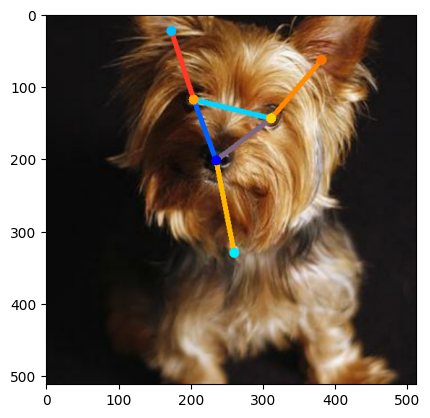

In [21]:
# Test determine_pose on a single image
it = iter(dataset)
sample = next(it)
output_image, annotated_image, black_image = determine_pose(sample['image'])
plt.imshow(annotated_image)

## Visualize

2023-04-16 14:20:27.425905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
2023-04-16 14:20:27.426224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4]
	 [[{{node Placeholder/_1}}]]


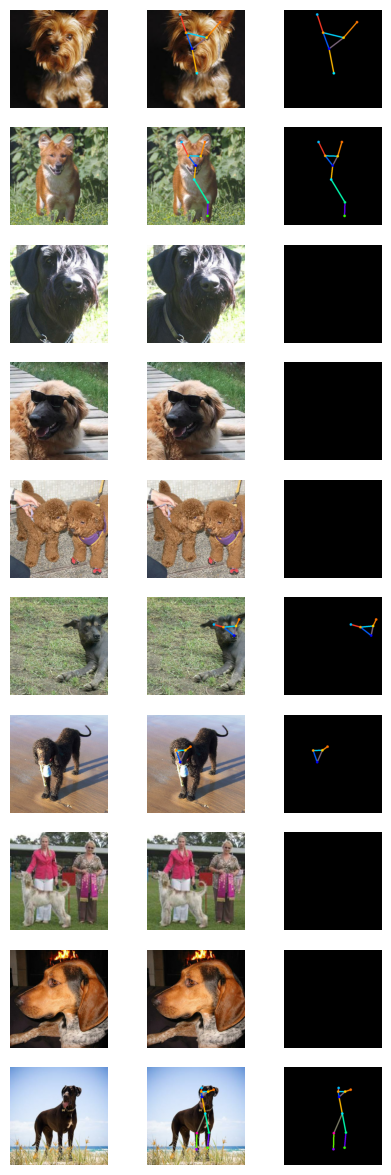

In [22]:
num_samples_to_vis = 10
fig, ax = plt.subplots(ncols=3, nrows=num_samples_to_vis, figsize=(5, 15))
for i, sample in enumerate(dataset.take(num_samples_to_vis).as_numpy_iterator()):
    
    
    sample = determine_pose(np.array(sample['image']))
    original_image = sample[0]
    annotated_image, blank_image = sample[1], sample[2]

    
    
    samples = [original_image, annotated_image, blank_image]
    titles = ["Input", "Annotation Overlaid", "Annotation"]

    for j in range(3):
        ax[i, j].imshow(samples[j])
        ax[i, j].axis("off")

In [23]:
import os
import hashlib
import PIL

## Caption generation with BLIP-2

For this section, we leverage an open-source and powerful pre-trained model for caption generation - [BLIP-2](https://huggingface.co/papers/2301.12597). This model comes with [different checkpoints](https://huggingface.co/models?other=blip-2), among which we're using [Salesforce/blip2-flan-t5-xl](https://huggingface.co/Salesforce/blip2-flan-t5-xl). 

🤗 Transformers also supports its predecessor - [BLIP](https://huggingface.co/papers/2201.12086). 

In the cell below, we first load the following classes: `Blip2Processor` and `Blip2ForConditionalGeneration`. Then we write a utility to generate captions for a given batch of images. 


In [25]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
import numpy as np


torch.cuda.empty_cache()


device = "cuda" if torch.cuda.is_available() else "cpu"
print('torch device', device)

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
captioning_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl", torch_dtype=torch.float16
)
captioning_model = captioning_model.to(device)


def generate_captions(images: np.ndarray) -> list[str]:
    """Generates captions for a batch of images.

    Args:
        images: A batch of images in the RGB format.

    Returns:
        A list of generated captions.
    """
    inputs = processor(images=images, return_tensors="pt").to(device, torch.float16)

    generated_ids = captioning_model.generate(**inputs)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    generated_texts = [text.strip() for text in generated_texts]
    return generated_texts

torch device cuda


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.50s/it]


## Serialize dataset

In this section, we serialize the original images, their corresponding conditioning images, and generate BLIP captions.

In [33]:
import tqdm

batch_size = 1
data_root = "data"
#new_dataset = dataset.batch(batch_size, drop_remainder=True)

os.makedirs(data_root, exist_ok=True)


def save_image(
    original_image: np.ndarray,
    overlaid_annotation: np.ndarray,
    blank_annotation: np.ndarray,
):
    """Serializes images to `data_root`."""
    image_hash = hashlib.sha1(original_image.tobytes()).hexdigest()
    PIL.Image.fromarray(original_image).save(
        os.path.join(data_root, f"{str(image_hash)}_original.png")
    )
    PIL.Image.fromarray(overlaid_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
    )
    PIL.Image.fromarray(blank_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_condition.png")
    )
    return image_hash


original_image_paths = []
overlaid_annotation_paths = []
blank_annotation_paths = []
all_generated_captions = []
total = 0

for samples in tqdm.tqdm(dataset.as_numpy_iterator()):
    samples = determine_pose(samples['image'])
    original_images = samples[0]
    overlaid_annotations = samples[1]
    blank_annotations = samples[2]

    generated_captions = generate_captions(original_images)


    image_hash = save_image(
        original_images, overlaid_annotations, blank_annotations
    )
    original_image_paths.append(
        os.path.join(data_root, f"{str(image_hash)}_original.png")
    )
    overlaid_annotation_paths.append(
        os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
    )
    blank_annotation_paths.append(
        os.path.join(data_root, f"{str(image_hash)}_condition.png")
    )

    all_generated_captions.append(generated_captions)

    total += 1

print(f"{total} samples will go in the final dataset.")

12000it [1:38:29,  2.03it/s]

6144000 samples will go in the final dataset.


## Create a 🤗 Dataset and push to the Hub

For this section, we leverage 🤗 Datasets to create a the final dataset that is ready to go with our [ControlNet training script](https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet_flax.py). 

Finally, we push the prepared dataset to Hub for easy sharing with the community. To be able to do that, you need to be a registered Hugging Face user to authenticate yourself. If you are not one already, please head over [hf.co](https://hf.co) and register youself; it's free =) 

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 

We start with a generator that yields a tuple consisting of:

* `original_image`
* `condtioning_image`
* `overlaid`
* `caption`

Note that `overlaid` image is just there for convenience. It is not **mandatory** for us to include it while creating the dataset as it won't be used during training. 

In [66]:
!pip install imageio

  Using cached imageio-2.27.0-py3-none-any.whl (3.4 MB)


In [76]:
from imageio import imread

def gen_examples():
    for i in range(len(original_image_paths)):
        im = imread(blank_annotation_paths[i])
        if not im.sum():
            continue
        else:
            yield {
                "original_image": {"path": original_image_paths[i]},
                "conditioning_image": {"path": blank_annotation_paths[i]},
                "overlaid": {"path": overlaid_annotation_paths[i]},
                "caption": all_generated_captions[i],
            }

In [ ]:
from datasets import Dataset, Features
from datasets import Image as ImageFeature
from datasets import Value

final_dataset = Dataset.from_generator(
    gen_examples,
    features=Features(
        original_image=ImageFeature(),
        conditioning_image=ImageFeature(),
        overlaid=ImageFeature(),
        caption=Value("string"),
    ),
    num_proc=6,
)

ds_name = "dog-poses-controlnet-dataset"
final_dataset.push_to_hub(ds_name)



Map:   0%|                                                                                                                          | 0/676 [00:00<?, ? examples/s]

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 676/676 [00:00<00:00, 1099.07 examples/s]

                                                                                                                                                                   

Pushing dataset shards to the dataset hub:   0%|                                                                                             | 0/9 [00:00<?, ?it/s]


Creating parquet from Arrow format:   0%|                                                                                                    | 0/1 [00:00<?, ?ba/s]


Creating parquet from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31ba/s]



Uplo

In [ ]:
len(original_image_paths), len(blank_annotation_paths), len(overlaid_annotation_paths), len(all_generated_captions)

Refer to [`from_generator()` documentation](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.from_generator) to know more about it. 

Note that, you can specify `private=True` in `push_to_hub` to host the dataset privately. 

